In [1]:
import sys
from pathlib import Path

# Add project root so `src` becomes importable
project_root = Path("..").resolve()
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

print("Added project root to sys.path:", project_root)


Added project root to sys.path: /home/cowen/mamba-optical-spectra


In [2]:
from pathlib import Path
import json
import numpy as np

import torch
import torch.nn as nn

from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt

from src.data.datasets import get_dataloaders, get_class_mapping
from src.models.mamba_1d import SpectraMamba  # REAL Mamba model


/home/cowen/mamba-optical-spectra/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
data_dir = Path("../data/processed")

loaders = get_dataloaders(
    data_dir=data_dir,
    batch_size=128,
    num_workers=0,
    normalize=True,
    pin_memory=False,
)

test_loader = loaders["test"]

class_map = get_class_mapping(data_dir)
class_map


{0: 'stable_single_mode',
 1: 'mode_hop',
 2: 'clipped',
 3: 'high_noise',
 4: 'multi_mode'}

In [4]:
# Use GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [5]:
# Adjust this path if your run-dir was different
checkpoint_path = Path("../experiments/logs/mamba_real_stable_small/best_mamba.pt")
assert checkpoint_path.exists(), f"Checkpoint not found at {checkpoint_path}"

checkpoint = torch.load(checkpoint_path, map_location=device)

checkpoint.keys()


/tmp/ipykernel_107770/2160789301.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


dict_keys(['model_state_dict', 'optimizer_state_dict', 'epoch', 'val_loss', 'val_acc', 'class_mapping'])

In [7]:
num_classes = len(class_map)

# This should match the config you used when training the checkpoint
model = SpectraMamba(
    num_classes=num_classes,
    in_channels=1,
    d_model=128,
    num_layers=6,
    d_state=16,
    d_conv=4,
    expand=2,
)

model.load_state_dict(checkpoint["model_state_dict"])
model.to(device)
model.eval()

print(f"Loaded Mamba model from {checkpoint_path}")
print(f"Trained to epoch: {checkpoint.get('epoch', 'N/A')}")
print(f"Best val acc recorded: {checkpoint.get('val_acc', 0.0) * 100:.2f}%")


Loaded Mamba model from ../experiments/logs/mamba_real_stable_small/best_mamba.pt
Trained to epoch: 20
Best val acc recorded: 97.40%


In [8]:
criterion = nn.CrossEntropyLoss()

all_targets = []
all_preds = []
test_loss = 0.0
total = 0

with torch.inference_mode():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, targets)

        test_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)

        total += targets.size(0)
        all_targets.append(targets.cpu().numpy())
        all_preds.append(predicted.cpu().numpy())

test_loss /= total
all_targets = np.concatenate(all_targets)
all_preds = np.concatenate(all_preds)

test_acc = (all_preds == all_targets).mean()

print(f"Test loss (Mamba): {test_loss:.4f}")
print(f"Test accuracy (Mamba): {test_acc * 100:.2f}%")


Test loss (Mamba): 0.0993
Test accuracy (Mamba): 97.00%


In [9]:
cm = confusion_matrix(all_targets, all_preds)
cm


array([[299,   0,  10,   0,   0],
       [  0, 303,   0,   0,   0],
       [  3,   0, 269,   0,   0],
       [  0,   0,   0, 316,   0],
       [  9,  10,  13,   0, 268]])

In [11]:
# Ensure a consistent order of classes
num_classes = len(class_map)
idx_to_name = [class_map[i] for i in range(num_classes)]

print("Class index to name mapping:")
for i, name in enumerate(idx_to_name):
    print(f"{i}: {name}")

Class index to name mapping:
0: stable_single_mode
1: mode_hop
2: clipped
3: high_noise
4: multi_mode


In [12]:
report = classification_report(all_targets, all_preds, target_names=idx_to_name)
print("Mamba classification report (test set):")
print(report)


Mamba classification report (test set):
                    precision    recall  f1-score   support

stable_single_mode       0.96      0.97      0.96       309
          mode_hop       0.97      1.00      0.98       303
           clipped       0.92      0.99      0.95       272
        high_noise       1.00      1.00      1.00       316
        multi_mode       1.00      0.89      0.94       300

          accuracy                           0.97      1500
         macro avg       0.97      0.97      0.97      1500
      weighted avg       0.97      0.97      0.97      1500



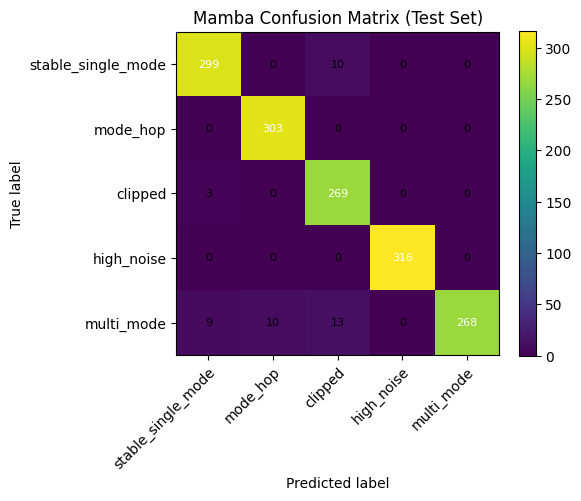

In [13]:
fig, ax = plt.subplots(figsize=(6, 5))

im = ax.imshow(cm, interpolation="nearest")
ax.figure.colorbar(im, ax=ax)

ax.set(
    xticks=np.arange(num_classes),
    yticks=np.arange(num_classes),
    xticklabels=idx_to_name,
    yticklabels=idx_to_name,
    ylabel="True label",
    xlabel="Predicted label",
    title="Mamba Confusion Matrix (Test Set)",
)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Annotate cells
thresh = cm.max() / 2.0
for i in range(num_classes):
    for j in range(num_classes):
        ax.text(
            j,
            i,
            cm[i, j],
            ha="center",
            va="center",
            color="white" if cm[i, j] > thresh else "black",
            fontsize=8,
        )

fig.tight_layout()
plt.show()


In [14]:
fig_dir = Path("../reports/figures")
fig_dir.mkdir(parents=True, exist_ok=True)

confmat_path = fig_dir / "mamba_confusion_matrix.png"
fig.savefig(confmat_path, dpi=200, bbox_inches="tight")

confmat_path


PosixPath('../reports/figures/mamba_confusion_matrix.png')

In [15]:
metrics = {
    "model": "SpectraMamba",
    "checkpoint_path": str(checkpoint_path),
    "epoch": int(checkpoint.get("epoch", -1)),
    "val_acc": float(checkpoint.get("val_acc", 0.0)),
    "test_acc": float(test_acc),
    "test_loss": float(test_loss),
    "class_mapping": class_map,
    "mamba_config": mamba_config,
}

metrics_dir = checkpoint_path.parent  # ../experiments/logs/mamba_real_stable_small
metrics_dir.mkdir(parents=True, exist_ok=True)
metrics_path = metrics_dir / "mamba_test_metrics.json"

with open(metrics_path, "w", encoding="utf-8") as f:
    json.dump(metrics, f, indent=2)

metrics_path


PosixPath('../experiments/logs/mamba_real_stable_small/mamba_test_metrics.json')